## Data from Barkley Canyon (summer 1997)

Data collectd as part of the Canadian Global Ocean Ecosystems Dynamics Program (GLOBEC) and reported in Allen, Vinderinho, Thomson, et al. 2001.


CTD's at 16 stations (July 25-27, 1997), 5 moorings (April 19 to October 2, 1997)  

Data structure in the CTD files is:
 
 name 0 = scan: scan number
 
 name 1 = pr: pressure [db]
 
 name 2 = t090: temperature, pri, ITS-90 [deg C]
 
 name 3 = t190: temperature, sec, ITS-90 [deg C]
 
 name 4 = sal00: salinity, PSS-78 [PSU], T0, C0
 
 name 5 = sal11: salinity, PSS-78 [PSU], T1, C1
 
 name 6 = c0S/m: conductivity, primary [S/m]
 
 name 7 = c1S/m: conductivity, secondary [S/m]
 
 name 8 = xmiss: transmissometer
 
 name 9 = flag:  0.000e+00

In [2]:
import cmocean as cmo
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.io
import scipy.interpolate as interpolate
import seaborn as sns
import matplotlib.gridspec as gspec


In [43]:
def rd_station(filename):
    '''This function reads the data in the cnv file `filename` from the Barkley 1997 data set and
    gives back a data frame, df, with 10 columns: 
    scanNo 
    pressure : in dbar
    temp0 :  temperature, pri, ITS-90 [deg C]
    temp1: temperature, sec, ITS-90 [deg C]
    sal0:  salinity, PSS-78 [PSU], T0, C0
    sal1:  salinity, PSS-78 [PSU], T1, C1
    cond0: conductivity, primary [S/m]
    cond1: conductivity, secondary [S/m]
    transmissometer: transmissometer
    flag: 0.000e+00
    '''
    
    df = pd.read_csv(filename, delim_whitespace=True, skiprows=59, header = None,
                     names = ['scanNo', 'pressure', 'temp0', 'temp1', 'sal0', 'sal1',
                              'cond0', 'cond1', 'transmissometer', 'flag'])
    
    return(df)

def get_coords(filename):
    '''Get the cooridnates of the CTD cast station in the file `filename`. This function returns a tuple with decimal lon,
    lat where lon is W and lat is N '''
    
    with open(filename) as f:
        lines = f.readlines()
        lat = float((lines[8])[18:21]) + float((lines[8])[21:26])/60.
        lon = float((lines[9])[19:22]) + float((lines[9])[22:28])/60
        
    return -lon,lat

def get_depth(filename):
    '''Get the depth of the CTD cast station in the file `filename`. This function returns a float
    depth (positive number)'''
    
    with open(filename) as f:
        lines = f.readlines()
        depth = float((lines[14])[13:16])
    return depth

def get_mean_xbottom(path_data, x_meters):
    '''
    INPUT
    pattern: a filename path to open those station files (.cnv)
    x_meters: float, meters from the bottom over which to average variables
    
    OUTPUT
    lon_sts, lat_sts, sal_sts, pres_sts, tmp_sts, dep_sts : numpy arrays of length = number 
    of files read with the mean variables over the bottom x_meters meters
    '''
    no_deep = ['97130229','97130203','97130227','97130237','97130209','97130215','97130217',
               '97130211','97130207','97130225','97130231','97130247','97130243','97130201','97130241',
               '97130213','97130221','97130249','97130205']

    # Get mean values for bottom x_meters m for all stations
    lon_sts = np.empty(len(no_deep))
    lat_sts = np.empty(len(no_deep))
    sal_sts = np.empty(len(no_deep))
    tmp_sts = np.empty(len(no_deep))
    pres_sts = np.empty(len(no_deep))
    dep_sts = np.empty(len(no_deep))

    for num, ii in zip(no_deep,range(len(lon_sts))):
        file = path_data + num + '.cnv'

        df_st = rd_station(file) # get dataframe, coords and depth at ctd station
        dep_sts[ii] = get_depth(file)
        lon_sts[ii], lat_sts[ii] = get_coords(file)

        bottom_df = (df_st.loc[df_st['pressure'] > (dep_sts[ii]-x_meters)]).mean(axis=0) # Mean bottom x_meters 
                                                                                           #(Assuming 1m = 1dbar)

        tmp_sts[ii] = bottom_df.temp0
        sal_sts[ii] = bottom_df.sal0
        pres_sts[ii] = bottom_df.pressure
        
    return (lon_sts, lat_sts, sal_sts, pres_sts, tmp_sts, dep_sts)

def get_mean_xtop(path_data, x_meters):
    '''
    INPUT
    pattern: a filename path to open those station files (.cnv)
    x_meters: float, meters from the bottom over which to average variables
    
    OUTPUT
    lon_sts, lat_sts, sal_sts, pres_sts, tmp_sts, dep_sts : numpy arrays of length = number 
    of files read with the mean variables over the bottom x_meters meters
    '''
    no_deep = ['97130229','97130203','97130227','97130237','97130209','97130215','97130217',
               '97130211','97130207','97130225','97130231','97130247','97130243','97130201','97130241',
               '97130213','97130221','97130249','97130205']

    # Get mean values for bottom x_meters m for all stations
    lon_sts = np.empty(len(no_deep))
    lat_sts = np.empty(len(no_deep))
    sal_sts = np.empty(len(no_deep))
    tmp_sts = np.empty(len(no_deep))
    pres_sts = np.empty(len(no_deep))
    dep_sts = np.empty(len(no_deep))

    for num, ii in zip(no_deep,range(len(lon_sts))):
        file = path_data + num + '.cnv'

        df_st = rd_station(file) # get dataframe, coords and depth at ctd station
        dep_sts[ii] = get_depth(file)
        lon_sts[ii], lat_sts[ii] = get_coords(file)

        top_df = (df_st.loc[df_st['pressure'] < (x_meters)]).mean(axis=0) # Mean top x_meters 
                                                                          #(Assuming 1m = 1dbar)

        tmp_sts[ii] = top_df.temp0
        sal_sts[ii] = top_df.sal0
        pres_sts[ii] = top_df.pressure
        
    return (lon_sts, lat_sts, sal_sts, pres_sts, tmp_sts, dep_sts)

def plot_circles(LON, LAT, SLT, PRES, TMP, DEP, x_meters_str):
    circle_size = 300

    fig, ax = plt.subplots(2,2, figsize=(12,8), sharey = True, sharex = True)

    # Draw bathymetries in all axes

    levels = [-1000,-750,-500,-300,-200,-150,-100,0]
    lon_slice = slice(530,680)
    lat_slice = slice(320,460)

    CS0 = ax[0,0].contour(lon[lon_slice], lat[lat_slice], dep[lat_slice,lon_slice], levels, linewidths = 1, colors='k')
    plt.clabel(CS0, inline=1, fmt='%1.0f',fontsize=13)
    CS1 = ax[0,1].contour(lon[lon_slice], lat[lat_slice], dep[lat_slice,lon_slice], levels, linewidths = 1, colors='k')
    plt.clabel(CS1, inline=1, fmt='%1.0f',fontsize=13)
    CS2 = ax[1,0].contour(lon[lon_slice], lat[lat_slice], dep[lat_slice,lon_slice], levels, linewidths = 1, colors='k')
    plt.clabel(CS2, inline=1, fmt='%1.0f',fontsize=13)
    CS3 = ax[1,1].contour(lon[lon_slice], lat[lat_slice], dep[lat_slice,lon_slice], levels, linewidths = 1, colors='k')
    plt.clabel(CS3, inline=1, fmt='%1.0f',fontsize=13)

    # set labels and titles
    ax[0,0].set_xlabel('lon')
    ax[0,0].set_ylabel('lat')
    ax[0,0].set_title('Salinity %s avg' %x_meters_str)

    ax[0,1].set_xlabel('lon')
    ax[0,1].set_ylabel('lat')
    ax[0,1].set_title('Pressure %s avg' %x_meters_str)

    ax[1,0].set_xlabel('lon')
    ax[1,0].set_ylabel('lat')
    ax[1,0].set_title('Temperature %s avg' %x_meters_str)
    ax[1,0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    ax[1,1].set_xlabel('lon')
    ax[1,1].set_ylabel('lat')
    ax[1,1].set_title('Depth at station' )
    ax[1,1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))


    # salinity
    s = ax[0,0].scatter(LON, LAT, s=circle_size, c=SLT, cmap=cmo.cm.dense)
    cb = plt.colorbar(s,ax=ax[0,0])
    cb.ax.set_xlabel('(PSU)')

    # pressure
    s = ax[0,1].scatter(LON, LAT, s=circle_size, c=PRES, cmap=cmo.cm.deep)
    cb = plt.colorbar(s,ax=ax[0,1])
    cb.ax.set_xlabel('(dbar)')

    # temp
    s = ax[1,0].scatter(LON, LAT, s=circle_size, c=TMP, cmap=cmo.cm.thermal)
    cb = plt.colorbar(s,ax=ax[1,0])
    cb.ax.set_xlabel(r'($^{\circ}$C)')

    # depth
    s = ax[1,1].scatter(LON, LAT, s=circle_size, c=DEP, cmap=cmo.cm.deep)
    cb = plt.colorbar(s,ax=ax[1,1])
    cb.ax.set_xlabel('(m)')

    plt.tight_layout()
    
    return 

def plot_circles_var(ax,LON, LAT, FLD, cmap, csize=100):
    circle_size = 100

    # Draw bathymetries in all axes
    levels = [-1000,-750,-500,-300,-200,-150,-100,0]
    lon_slice = slice(530,680)
    lat_slice = slice(320,460)

    CS0 = ax.contour(lon[lon_slice], lat[lat_slice], dep[lat_slice,lon_slice], levels, linewidths=1, colors='0.5')
    plt.clabel(CS0, inline=1, fmt='%1.0f',fontsize=8)
   
    s = ax.scatter(LON, LAT, s=circle_size, c=FLD, cmap=cmap, edgecolors='0.5', linewidths=1)
    cb = plt.colorbar(s,ax=ax, ticks=[np.linspace(np.nanmin(FLD),np.nanmax(FLD),5)], format='%1.1f')
    
    # set labels and titles
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_aspect(1)
    cb.ax.yaxis.set_tick_params(pad=1)
    ax.yaxis.set_tick_params(pad=1)
    ax.xaxis.set_tick_params(pad=1)

def plot_profile(ax, file, col, lab, sal=True):
    with open(file) as f:
        print(f.readlines( )[13])
        df_TT = rd_station(file) # get dataframe, coords and depth at ctd station
        if sal==True:
            ax.plot(df_TT.sal0, -df_TT.pressure, color = col, label = lab)
        else:
            ax.plot(df_TT.temp0, -df_TT.pressure, color = col, label = lab)
        ax.yaxis.set_tick_params(pad=1)
        ax.xaxis.set_tick_params(pad=1)
      

In [4]:
path_data = '/home/kramosmu/Research/Carine_data/'


In [5]:
sns.set_context('paper')

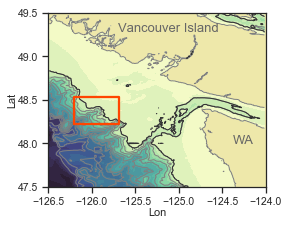

In [6]:
sns.set_style('ticks')
sns.set_context('talk', font_scale=0.8)
# plot stations
bathy = scipy.io.loadmat('/home/kramosmu/Research/Bathymetries/SouthVIgrid.mat')
dict.keys(bathy)

vigrid = bathy['SouthVIgrid']
lon = vigrid[0,0][0]
lon = np.squeeze(np.transpose(lon))
lat = vigrid[0,0][1]
lat = np.squeeze(np.transpose(lat))
dep = vigrid[0,0][2]

lon_slice = slice(445,1175)
lat_slice = slice(0,900)

plt.rcParams['contour.negative_linestyle'] = 'solid'

# big map
fig, ax = plt.subplots(1,1, figsize=(4.5,3.2))
ax.set_facecolor('palegoldenrod')

CS1 = ax.contourf(lon[lon_slice], lat[lat_slice], dep[lat_slice,lon_slice], np.linspace(-2400,0,26), cmap=cmo.cm.deep_r)
#cb = plt.colorbar(CS1, ax=ax)
#cb.ax.set_xlabel('(m)')
CS3 = ax.contour(lon[lon_slice], lat[lat_slice], dep[lat_slice,lon_slice], (-2000,-1800,-1600,-1400,-1200,-1000,-800,-600,-400,-200,0),linewidths = 1, colors='0.5')
CS3 = ax.contour(lon[lon_slice], lat[lat_slice], dep[lat_slice,lon_slice], [-200],linewidths = 1, colors='0.2')

ax.plot((lon[530],lon[680],lon[680],lon[530],lon[530]),(lat[320],lat[320],lat[460],lat[460],lat[320]), 
        '-',color='OrangeRed')

ax.set_xlabel('Lon', fontsize=11, labelpad=1)
ax.set_ylabel('Lat', fontsize=11, labelpad=1)

ax.yaxis.set_ticks([47.5,48.0,48.5,49.0,49.5])
ax.xaxis.set_ticks([-126.5,-126,-125.5,-125,-124.5,-124])

ax.yaxis.set_tick_params(pad=4)
ax.xaxis.set_tick_params(pad=4)

ax.text(0.32,0.89,'Vancouver Island',transform=ax.transAxes,fontsize=13, color='0.4')
ax.text(0.85,0.25,'WA',transform=ax.transAxes,fontsize=13, color='0.4')

ax.set_aspect('equal')


** STATION:   BCD2

** STATION:   BCD2

** STATION:   BCA1

** STATION:   BCA1



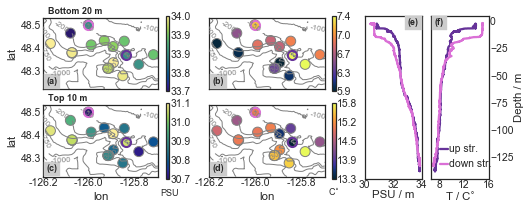

In [57]:
plt.rcParams.update({'font.size': 9})
sns.set_style('white')
lon20, lat20, sal20, pres20, tmp20, dep20 = get_mean_xbottom(path_data ,20.0)
lon10, lat10, sal10, pres10, tmp10, dep10 = get_mean_xtop(path_data ,10.0)

fig = plt.figure(figsize=(8,3))
gs = gspec.GridSpec(1,2, hspace=0.01,wspace=0.05, width_ratios=[2.5,1])
gs0 = gspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0],hspace=0.15,wspace=0.15)
gs1 = gspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs[1],hspace=0.15,wspace=0.15)

ax0 = plt.subplot(gs0[0,0])
ax1 = plt.subplot(gs0[0,1])
ax2 = plt.subplot(gs0[1,0])
ax3 = plt.subplot(gs0[1,1])
ax4 = plt.subplot(gs1[0])
ax5 = plt.subplot(gs1[1])

plot_circles_var(ax0,lon20, lat20, sal20, cmo.cm.haline)
plot_circles_var(ax1,lon20, lat20, tmp20, cmo.cm.thermal)

plot_circles_var(ax2,lon10, lat10, sal10, cmo.cm.haline)
plot_circles_var(ax3,lon10, lat10, tmp10, cmo.cm.thermal)

ax0.set_xticks([])
ax0.set_xlabel('')
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel('')
ax1.set_xlabel('')
ax3.set_ylabel('')
ax3.set_yticks([])

file1 = path_data + '97130207' + '.cnv'
plot_profile(ax4,file1 ,  'rebeccapurple', 'up str.',sal=True)
plot_profile(ax5,file1 ,  'rebeccapurple', 'up str.',sal=False)

file2 = path_data + '97130211' + '.cnv'
plot_profile(ax4,file2 ,  'orchid', 'down str.',sal=True)
plot_profile(ax5,file2 ,  'orchid', 'down str.',sal=False)
ax5.legend(loc=0,handlelength=0.7, handletextpad=0.1 )

ax4.set_yticks([])
ax4.set_ylabel('')
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position("right")
ax5.set_ylabel('Depth / m',labelpad=0)
ax4.set_xlabel('PSU / m',labelpad=0 )
ax5.set_xlabel('T / C$^{\circ}$',labelpad=0 )
ax4.set_xticks([30,32,34])
ax5.set_xticks([8,12,16])

latt1,lonn1 = get_coords(file1)
latt2,lonn2 = get_coords(file2)

for ax in [ax0,ax1,ax2,ax3]:
    ax.plot(latt1, lonn1, 'o', markeredgewidth=2, markerfacecolor="None", markeredgecolor='rebeccapurple')
    ax.plot(latt2, lonn2, 'o', markeredgewidth=2, markerfacecolor="None", markeredgecolor='orchid')

ax3.text(1.03,-0.26, r'C$^{\circ}$', transform=ax3.transAxes)
ax2.text(1.02,-0.27, r'PSU', transform=ax2.transAxes, fontsize=9)

ax0.text(0.032,0.072, r'(a)',fontweight='bold', transform=ax0.transAxes,bbox=dict(boxstyle="square",ec='0.8',fc='0.8'))
ax1.text(0.03,0.072, r'(b)',fontweight='bold', transform=ax1.transAxes,bbox=dict(boxstyle="square",ec='0.8',fc='0.8'))
ax2.text(0.032,0.072, r'(c)',fontweight='bold', transform=ax2.transAxes,bbox=dict(boxstyle="square",ec='0.8',fc='0.8'))
ax3.text(0.03,0.072, r'(d)',fontweight='bold', transform=ax3.transAxes,bbox=dict(boxstyle="square",ec='0.8',fc='0.8'))
ax4.text(0.75,0.94, r'(e)',fontweight='bold', transform=ax4.transAxes,bbox=dict(boxstyle="square",ec='0.8',fc='0.8'))
ax5.text(0.065,0.94, r'(f)',fontweight='bold', transform=ax5.transAxes,bbox=dict(boxstyle="square",ec='0.8',fc='0.8'))

ax0.text(0.05,1.05, r'Bottom 20 m',fontweight='bold', transform=ax0.transAxes)
ax2.text(0.05,1.05, r'Top 10 m',fontweight='bold', transform=ax2.transAxes)

plt.savefig('Barkley_pool.pdf', format='pdf',bbox_inches='tight')